In [1]:
# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
library(xgboost)
library(moments)  # skewness

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: xgboost


In [2]:
# load the data set
data = read.csv('./train.csv')

In [3]:
# compute the number of missing values in each column
num.NA = colSums(apply(data[, -c(1, 81)], 2, is.na))
data.type = sapply(data[, names(which(num.NA != 0))], class)

In [4]:
# drop column of Alley, PoolQC, Fence, MiscFeature
drop.names = c("Alley", "PoolQC", "Fence", "MiscFeature")
data = data[ , !(names(data) %in% drop.names)]

In [5]:
# find all categorical and numerical variables
data.type = sapply(data[ , -c(1, ncol(data))], class)
categorical.var = names(data)[which(c(NA, data.type, NA) == 'factor')]
numerical.var = names(data)[which(c(NA, data.type, NA) == 'integer')]

In [6]:
# create new feature named "NA" for categorical variables
for (i in categorical.var) {
    data[, i] = addNA(data[, i])
}

In [7]:
# create new feature using the median value for numerical variables
numerical.missing.var = c('LotFrontage', 'MasVnrArea', 'GarageYrBlt')
for (i in numerical.missing.var) {
    na.id = is.na(data[, i])
    tmp.median = median(data[, i], na.rm=TRUE)
    data[which(na.id), i] = tmp.median
#     data[, paste(i, 'NAInd', sep='_')] = as.numeric(na.id)
}

In [8]:
# transform the response variable into log scale
data$SalePrice = log(data$SalePrice + 1)

# transform numerical feature whose skewness is larger than 0.75
skewed.features = sapply(data[, numerical.var], skewness)
skewed.features = numerical.var[which(skewed.features > 0.75)]
for (i in skewed.features) {
    data[, i] = log(data[, i] + 1)
}

In [9]:
# directly transform "Street", "Utilities" and "CentralAir" into 0-1 values
data[, 'Street'] = as.numeric(data[, 'Street']) - 1
data[, 'Utilities'] = as.numeric(data[, 'Utilities']) - 1
data[, 'CentralAir'] = as.numeric(data[, 'CentralAir']) - 1

In [10]:
# find new categorical variable to create dummy variables
categorical.var = names(which(sapply(data[, categorical.var], function(x) length(unique(x))) > 2))
dummy.var = data.frame(dummy.data.frame(data[, categorical.var], sep='.'))
data = cbind(data, dummy.var)

In [11]:
# drop original categorical variables
data = data[ , !(names(data) %in% categorical.var)]

# xgboost model

In [12]:
# get x and y variables
data.y = as.numeric(data[, 41])
data.x = data[, c(-1, -41)]
data.x = apply(data.x, 2, as.numeric)

In [13]:
set.seed(100)
cv.dum = xgb.cv(data=data.x, label=data.y, nfold=5, max.depth=2, 
                eta=1, nround=10, objective='reg:linear')
cat('\n')
bst.dum = xgboost(data=data.x, label=data.y, max.depth=2, eta=1, 
                  nround=10, objective='reg:linear')

[1]	train-rmse:0.399375+0.004733	test-rmse:0.399298+0.018786 
[2]	train-rmse:0.247774+0.004589	test-rmse:0.253076+0.017702 
[3]	train-rmse:0.212437+0.004851	test-rmse:0.227975+0.015115 
[4]	train-rmse:0.197967+0.004579	test-rmse:0.217213+0.014913 
[5]	train-rmse:0.186223+0.006324	test-rmse:0.210608+0.012450 
[6]	train-rmse:0.177458+0.006189	test-rmse:0.204019+0.013405 
[7]	train-rmse:0.168980+0.005644	test-rmse:0.195784+0.011861 
[8]	train-rmse:0.164291+0.005647	test-rmse:0.195603+0.015103 
[9]	train-rmse:0.159002+0.006508	test-rmse:0.190105+0.014031 
[10]	train-rmse:0.154362+0.006522	test-rmse:0.187882+0.012233 

[1]	train-rmse:0.399390 
[2]	train-rmse:0.248025 
[3]	train-rmse:0.213762 
[4]	train-rmse:0.199496 
[5]	train-rmse:0.183718 
[6]	train-rmse:0.175831 
[7]	train-rmse:0.167734 
[8]	train-rmse:0.161699 
[9]	train-rmse:0.156076 
[10]	train-rmse:0.152077 


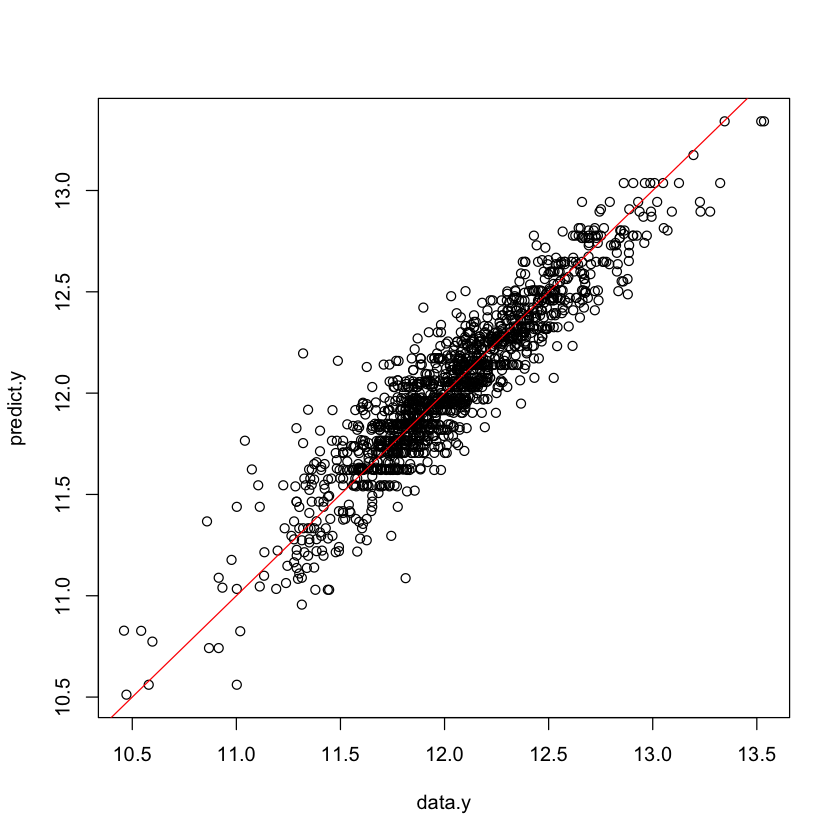

In [14]:
# predict on the training set
predict.y = predict(bst.dum, data.x)
plot(data.y, predict.y)
lines(x = c(10,14), y = c(10,14), col='red')

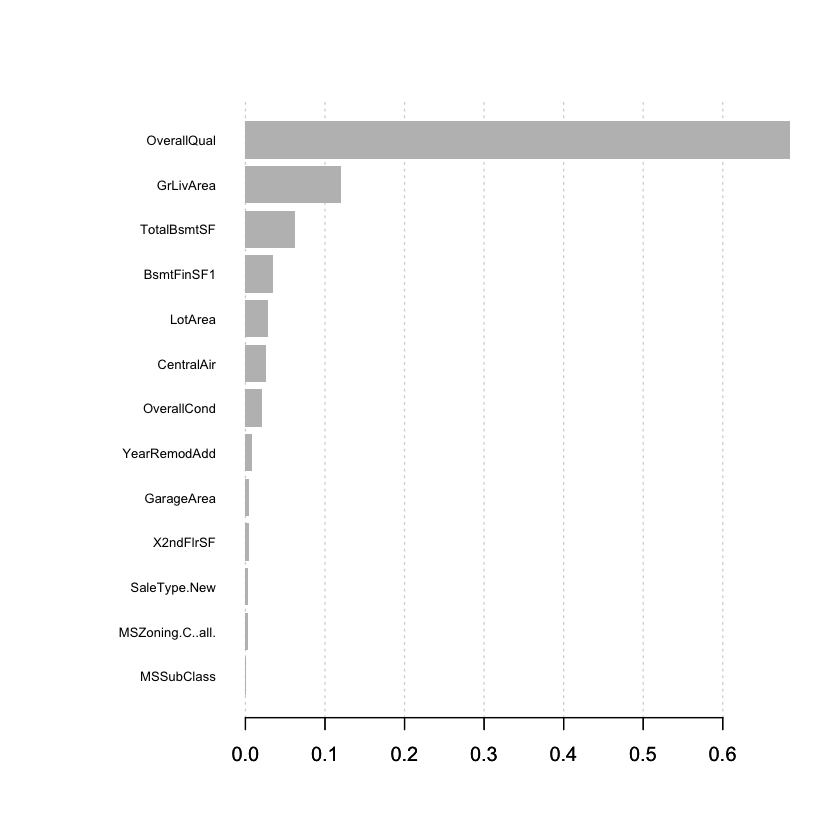

In [15]:
importance_matrix = xgb.importance(names(data[, c(-1, -41)]), model=bst.dum)
xgb.plot.importance(importance_matrix)